# LEO Objects
Create statistics for LEO objects.

LEO (low Earth orbit) is a highly populated region around the Earth, defined as Earth-centered orbits with an orbital period lower or equal 128 minutes and a maximum eccentricity of 0.25.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

from matplotlib.patches import Ellipse

import numpy as np

from satdb import DBConfig, Dbase, tools

ModuleNotFoundError: No module named 'satdb'

## Define some constants.

A template for the configuration file `satdb.yaml` can be found [here](https://raw.githubusercontent.com/rzbrk/satdb/master/satdb_example.yaml).

In [36]:
## Config file
config_file = "../satdb.yaml"

## Earth radius [km]
mrad = 6378.137

## Number of bins for histogram plots
n_bins = 38

## Define the matplotlib figure size
plt.rcParams["figure.figsize"] = (9,9)

In [3]:
config = DBConfig(config_file)
dbc = Dbase(config)
dbc.connect()

In [4]:
sql = """
select o.norad, o.semimajor_axis, o.eccentricity, o.inclination, m.obj_type from orbelem as o
inner join metadata as m on o.norad=m.norad
where (o.norad, o.epoch) in
(select norad,max(epoch) from orbelem group by norad)
and period < 128.0 and eccentricity < 0.25
"""
res = dbc.fetchall(sql, None)

Sort the data from the database query by object type (payload == satellite, rocket body, debris and all objects)

In [42]:
# PAYLOAD
pl_sma = []
pl_ecc = []
pl_incl = []
# ROCKET BODY
rb_sma = []
rb_ecc = []
rb_incl = []
# DEBRIS
sd_sma = []
sd_ecc = []
sd_incl = []
# TBA, None, ...
un_sma = []
un_ecc = []
un_incl = []
# ISS (NORAD: 25544)
iss_sma = None
iss_ecc = None
iss_incl = None

for r in res:
    if r[4] == "PAYLOAD":
        pl_sma.append(r[1] - mrad)
        pl_ecc.append(r[2])
        pl_incl.append(r[3])
    elif r[4] == "ROCKET BODY":
        rb_sma.append(r[1] - mrad)
        rb_ecc.append(r[2])
        rb_incl.append(r[3])
    elif r[4] == "DEBRIS":
        sd_sma.append(r[1] - mrad)
        sd_ecc.append(r[2])
        sd_incl.append(r[3])
    else:
        un_sma.append(r[1] - mrad)
        un_ecc.append(r[2])
        un_incl.append(r[3])
        
    if r[0] == 25544:
        iss_sma = r[1] - mrad
        iss_ecc = r[2]
        iss_incl = r[3]
              
all_sma = pl_sma + rb_sma + sd_sma + un_sma
all_ecc = pl_ecc + rb_ecc + sd_ecc + un_ecc
all_incl = pl_incl + rb_incl + sd_incl + un_incl


## 3D Plot: Altitude - Eccentricity - Inclination

<IPython.core.display.Javascript object>


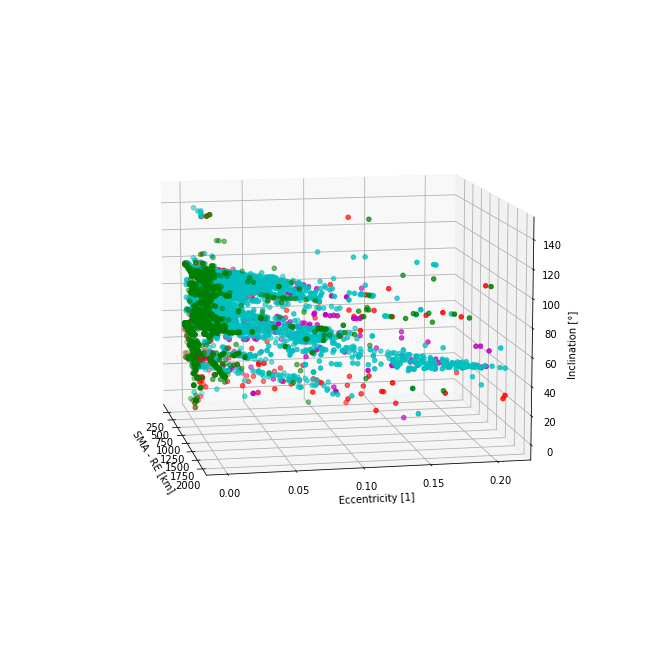

Text(0.5, 0, 'Inclination [°]')

In [43]:
fig_sei = plt.figure()
ax = fig_sei.add_subplot(projection='3d')

ax.scatter(sd_sma, sd_ecc, sd_incl, marker='o', color='c')
ax.scatter(un_sma, un_ecc, un_incl, marker='o', color='m')
ax.scatter(pl_sma, pl_ecc, pl_incl, marker='o', color='g')
ax.scatter(rb_sma, rb_ecc, rb_incl, marker='o', color='r')

ax.set_xlabel('SMA - RE [km]')
ax.set_ylabel('Eccentricity [1]')
ax.set_zlabel('Inclination [°]')

## Inclination

<IPython.core.display.Javascript object>


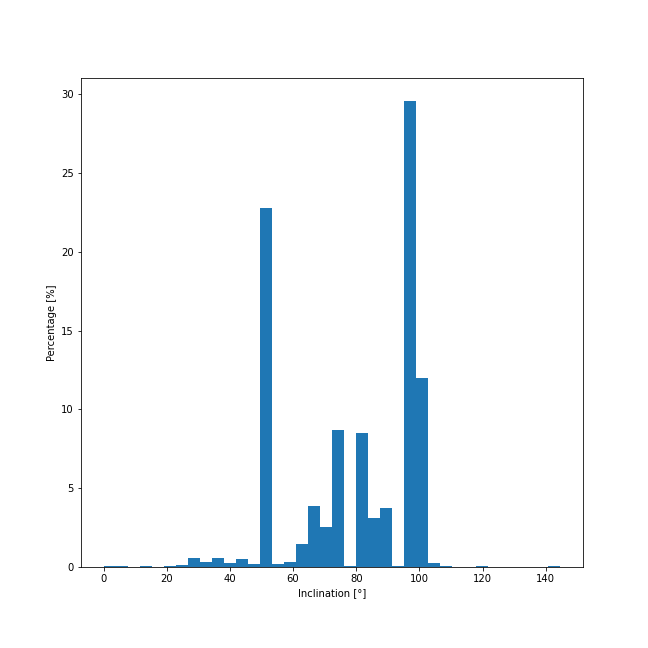

Text(0, 0.5, 'Percentage [%]')

In [37]:
fig_incl_hist = plt.figure()
ax = fig_incl_hist.add_subplot()

counts, bins = np.histogram(all_incl, bins=n_bins)
percent = [i/sum(counts)*100 for i in counts]

ax.hist(bins[:-1], bins, weights=percent)
ax.set_xlabel('Inclination [°]')
ax.set_ylabel('Percentage [%]')

The inclination for LEO objects is not evenly distributed. Most objects have an inclination ~100 degrees, meaning, they are in a [retrograde orbit](https://en.wikipedia.org/wiki/Retrograde_and_prograde_motion). The precession of these orbits is choosed such, that the orientation of the orbital plane to the sun is constant ([(sun-synchronous orbits or SSO)](https://en.wikipedia.org/wiki/Sun-synchronous_orbit). SSO is useful for a wide range of space applications, especially Earth observation of weather satellites.

Another peak around ~ 50 degrees is visible. This peak is dominated by satellites from the [Starlink](https://en.wikipedia.org/wiki/Starlink) or [Globalstar](https://en.wikipedia.org/wiki/Globalstar) constellations.

## Mean Altitude
The mean altitude is computed as the semimajor axis substracted by the Earth radius.

<IPython.core.display.Javascript object>


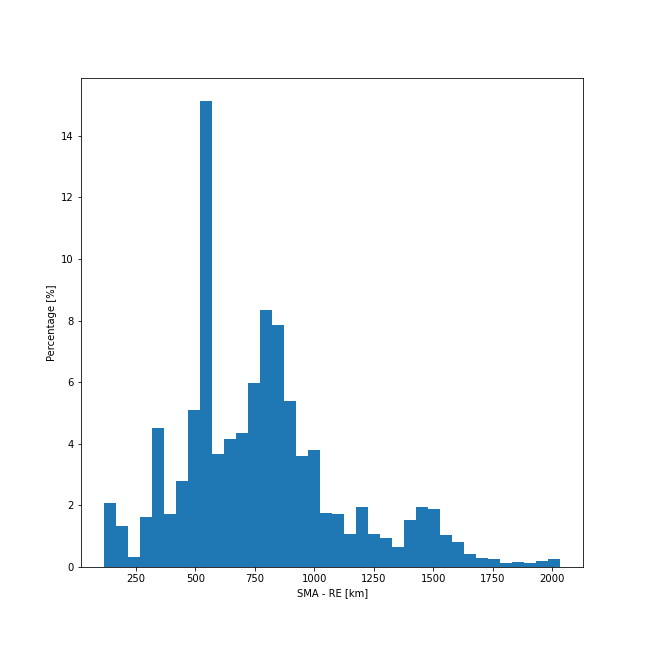

Bin size: 50.5128947368421


In [38]:
fig_sma_hist = plt.figure()
ax = fig_sma_hist.add_subplot()

counts, bins = np.histogram(all_sma, bins=n_bins)
percent = [i/sum(counts)*100 for i in counts]

ax.hist(bins[:-1], bins, weights=percent)
ax.set_xlabel('SMA - RE [km]')
ax.set_ylabel('Percentage [%]')

print("Bin size:", bins[1]-bins[0])

Many satellites were placed in orbits ~ 500 km above the Earth's surface. Many of those satellites are part of larger constellations, like [Starlink](https://en.wikipedia.org/wiki/Starlink), [Flock/Dove (Planet Labs)](https://en.wikipedia.org/wiki/Planet_Labs#Flock_satellite_constellations), [Lemur (Spire Global)](https://en.wikipedia.org/wiki/Spire_Global), [OneWeb (WorldVu)](https://en.wikipedia.org/wiki/OneWeb), [SpaceBEE (Swarm Technologies)](https://en.wikipedia.org/wiki/Swarm_Technologies#Satellite_constellation) and others.

At ~ 800 km other constellations like [Iridium](https://en.wikipedia.org/wiki/Iridium_satellite_constellation), OneWeb, [Orbcomm](https://en.wikipedia.org/wiki/Orbcomm) reside. At this altitude also the [Russian Meteor 1/2](https://en.wikipedia.org/wiki/Meteor_(satellite) as well as the American [NOAA](https://en.wikipedia.org/wiki/Television_Infrared_Observation_Satellite) weather satellites were or are operated.

Another popular orbital regime is around 1450 km. Again, this population is mainly formed by constellations, in this case Globalstar or [Gonets](https://en.wikipedia.org/wiki/Gonets). A couple of Russian Cosmos satellites can be found here which were launched in the 1970 and later. This were used for governmental communation purposes and partly later reused for Gonets.

## Eccentricity

<IPython.core.display.Javascript object>


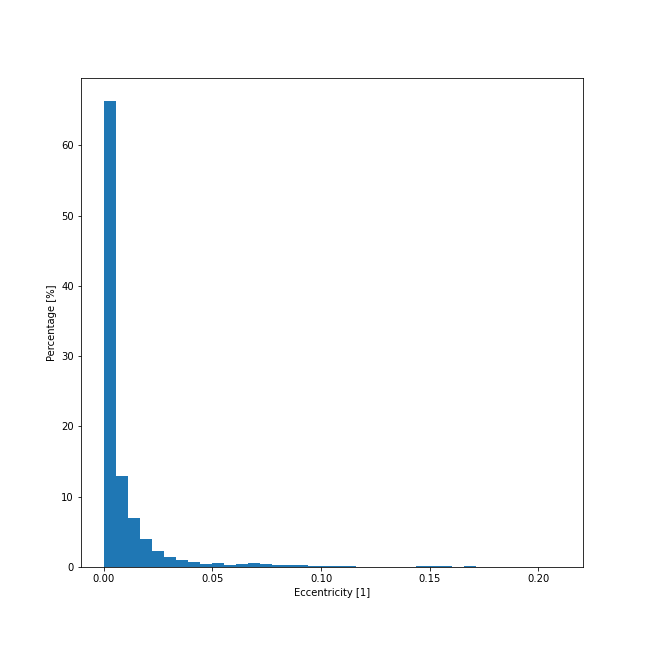

Text(0, 0.5, 'Percentage [%]')

In [39]:
fig_ecc_hist = plt.figure()
ax = fig_ecc_hist.add_subplot()

counts, bins = np.histogram(all_ecc, bins=n_bins)
percent = [i/sum(counts)*100 for i in counts]

ax.hist(bins[:-1], bins, weights=percent)
ax.set_xlabel('Eccentricity [1]')
ax.set_ylabel('Percentage [%]')

Most LEO orbits have very low eccentricity meaning the orbits are basically circular.

## Inclination versus Altitude

<IPython.core.display.Javascript object>


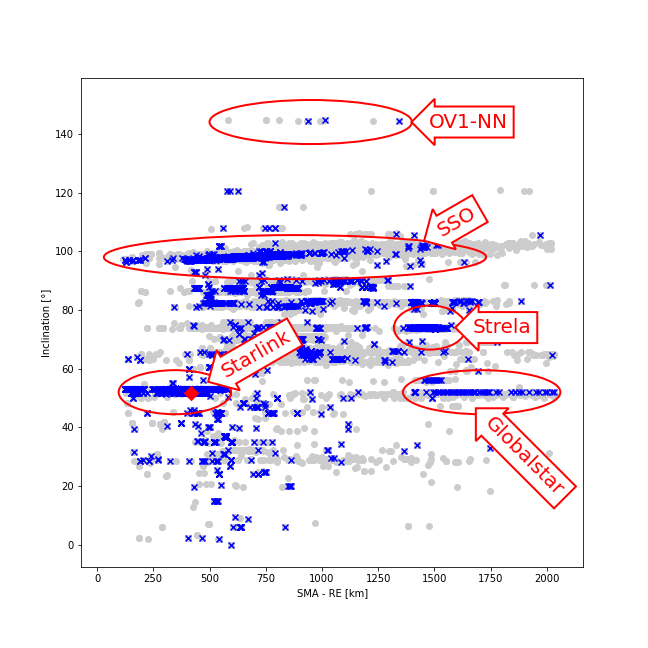

In [49]:
fig_incl_sma = plt.figure()
ax = fig_incl_sma.add_subplot()
ax.scatter(all_sma, all_incl, marker='o', color='0.8')
#ax.scatter(rb_sma, rb_incl, marker='x', color='r')
ax.scatter(pl_sma, pl_incl, marker='x', color='b')
ax.set_xlabel('SMA - RE [km]')
ax.set_ylabel('Inclination [°]')

# OV1-NN Experimental satellites launched 1960th
sso = Ellipse(xy=(950., 144.), width=900., height=15., edgecolor='r', fc='None', lw=2)
ax.add_patch(sso)
ax.text(1650., 144., "OV1-NN", ha="center", va="center", rotation=0, size=20, color='r',
       bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="Red", lw=2))

# Sun-synchronous satellites
sso = Ellipse(xy=(880., 98.), width=1700., height=15., edgecolor='r', fc='None', lw=2)
ax.add_patch(sso)
ax.text(1600., 110., "SSO", ha="center", va="center", rotation=30, size=20, color='r',
       bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="Red", lw=2))

# Starlinks
starlinks = Ellipse(xy=(346., 52.), width=500., height=15., edgecolor='r', fc='None', lw=2)
ax.add_patch(starlinks)
ax.text(708., 65., "Starlink", ha="center", va="center", rotation=30, size=20, color='r',
       bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="Red", lw=2))

# Globalstar
globalstar = Ellipse(xy=(1710., 52.), width=700., height=15., edgecolor='r', fc='None', lw=2)
ax.add_patch(globalstar)
ax.text(1900., 30., "Globalstar", ha="center", va="center", rotation=-45, size=20, color='r',
       bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="Red", lw=2))

# Strela
strela = Ellipse(xy=(1480., 74.), width=320., height=15., edgecolor='r', fc='None', lw=2)
ax.add_patch(strela)
ax.text(1800., 74., "Strela", ha="center", va="center", rotation=0, size=20, color='r',
       bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="Red", lw=2))

# ISS
ax.scatter(iss_sma, iss_incl, marker='D', s=100, color='Red')


The grey dots are all space objects from the database. The blue crosses are the satellites (payloads only).

In the inclination over altitude plot a pattern of horizontal lines are visible, meaning regions in LEO with equal inclination but varying altitude. Some groups can be associated with the already above mentioned constellations.

The red diamond denotes the inclination and altitude for the International Space Station (ISS).

<IPython.core.display.Javascript object>


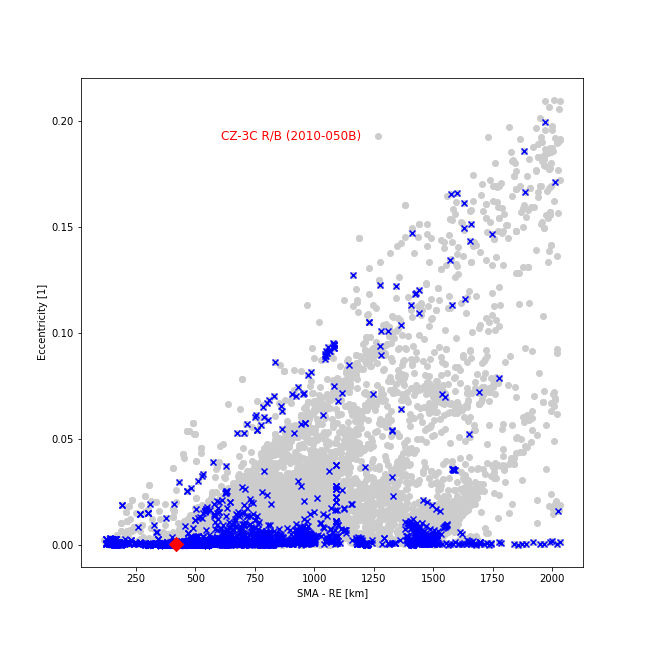

In [50]:
fig_ecc_sma = plt.figure()
ax = fig_ecc_sma.add_subplot()
ax.scatter(all_sma, all_ecc, marker='o', color='0.8')
#ax.scatter(rb_sma, rb_ecc, marker='x', color='r')
ax.scatter(pl_sma, pl_ecc, marker='x', color='b')
ax.set_xlabel('SMA - RE [km]')
ax.set_ylabel('Eccentricity [1]')

ax.text(900., 0.193, "CZ-3C R/B (2010-050B)", ha="center", va="center", rotation=0, size=12, color='r')

# ISS
ax.scatter(iss_sma, iss_ecc, marker='D', s=100, color='Red')

The grey dots are all space objects from the database. The blue crosses are the satellites (payloads only). The red diamond is the ISS.

As seen above, the typical eccentricity of LEO orbits is very low meaning LEO orbits are typically circular. This plot shows, that the lower the altitude the lower the eccentricity. This is because of the deacceleration by the thin upper atmosphere.

The orbital eccentricity $e$ is a parameter defining the shape of an orbit and can be computed from the periapsis $r_p$ and apoapsis $r_a$ by the following formula:

$e={r_a-r_p}/{r_a+r_p}$

For LEO orbits the eccentricity ranges between 0 (circular orbit) and lower-than 1 (elliptical orbit). An orbit with an initially high eccentricity means a very elliptical orbit with a comparably low periapsis and comparably high apoapsis. Because the density of the upper atmosphere decays exponentionally with the altitude the deacceleration experienced by a space object is highest around the pericenter. This will reduce the speed or the orbital energy of the object resulting in a reduction of the apoapsis. This is repeated for every pass of the object through the pericenter. In the consequence over time, without any orbital maintenance the apoapsis as well as the eccentricity of the space object is reduced. The effect is stronger if the mean altitude or the semimajor axis of the orbit is smaller, because then the whole orbit is nearer to the Earth where the atmospheric drag is higher. Therefore, for low altitude orbits an initial eccentricity is very effectively reduced by atmospeheric drag. See also [this article](https://academic.oup.com/mnras/article/410/1/654/1037987).

The plot shows a very interesting "outlier" with a comparably high eccentricity. The object is a [Chinese Long March 3C](https://en.wikipedia.org/wiki/Long_March_3C) upper stage (2010-050B), launched 2020-10-01 to bring the [Chang'e 2 spacecraft](https://en.wikipedia.org/wiki/Chang%27e_2) to the Moon. Due to Lunar pertubation the long-term behaviour of this orbit is rather [chaotic](https://sattrackcam.blogspot.com/2015/07/rapid-tumbling-of-change-2-rb-2010-050b.html).